In [197]:
from pycaret.time_series import *
import pandas as pd

df = pd.read_csv("province/data_eng_day.csv", parse_dates=["timestamp"], index_col="timestamp")
df.index = df.index.normalize()
df = df.drop(columns=["Unnamed: 0"])

print(df.index.duplicated().sum())  # นับจำนวน index ที่ซ้ำกัน
print(df.index[df.index.duplicated()])  # แสดงค่าที่ซ้ำ
df = df[~df.index.duplicated(keep="last")]
df = df.asfreq("D")  # ตั้งค่าความถี่เป็นรายวัน
df = df.interpolate()


# แปลงคอลัมน์ timestamp ให้เป็น DatetimeIndex หากยังไม่ได้ทำ
df.index = pd.to_datetime(df.index)
# ตรวจสอบให้แน่ใจว่าไม่มีคอลัมน์ที่ไม่ต้องการ
df = df[['pm_2_5', 'humidity', 'pm_10', 'temperature']]  # ใช้เฉพาะคอลัมน์ที่ต้องการ

# ลองเรียกใช้งาน setup อีกครั้ง
train_size = int(len(df))-7
train_df = df.iloc[:train_size]  # ใช้ข้อมูลก่อนหน้าทั้งหมดเป็น train set
test_df = df.iloc[train_size:]  
train_df.index = train_df.index.to_period("D")
test_df.index = test_df.index.to_period("D")
print(len(train_df), len(test_df))

1
DatetimeIndex(['2025-02-11'], dtype='datetime64[ns]', name='timestamp', freq=None)
676 7


In [198]:
from pycaret.time_series import TSForecastingExperiment
s = TSForecastingExperiment()


target = 'pm_2_5'
print(train_df["pm_2_5"])

# เรียก setup() โดยใช้ train_df
exp = setup(train_df, target=target, fh=7, session_id=123, fold_strategy='expanding',seasonal_period=12, use_gpu=True)



timestamp
2023-04-01     4.727273
2023-04-02     9.656243
2023-04-03    14.585213
2023-04-04    11.938022
2023-04-05    10.733566
                ...    
2025-01-31    24.003417
2025-02-01    31.669725
2025-02-02    32.655212
2025-02-03    35.094660
2025-02-04    24.459172
Freq: D, Name: pm_2_5, Length: 676, dtype: float64


,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(676, 4)"
5,Transformed data shape,"(676, 4)"
6,Transformed train set shape,"(669, 4)"
7,Transformed test set shape,"(7, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

In [199]:
df.tail(10)

,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2025-02-02,32.655212,70.341639,37.697595,27.683890
2025-02-03,35.094660,65.114261,39.898058,28.644544
2025-02-04,24.459172,70.266522,28.523077,27.775432
2025-02-05,13.987089,71.500943,16.699531,28.327450
2025-02-06,19.454865,69.511783,23.709261,28.579177
2025-02-07,29.321219,70.933952,34.743259,28.271927
2025-02-08,26.000000,69.348548,30.654249,28.385596
2025-02-09,24.616898,69.916384,28.971065,28.373742
2025-02-10,25.856981,71.226336,30.652667,28.251201


In [200]:
best = create_model("auto_arima")
# arima_model = create_model("auto_arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.0376,0.0404,0.3657,0.5090,0.0093,0.0094,0.9923
1,2025-01-14,0.0970,0.0811,0.9553,1.0341,0.0422,0.0411,0.9927
2,2025-01-21,0.0602,0.0551,0.5932,0.7024,0.0237,0.0233,0.9946
Mean,NaT,0.0649,0.0589,0.6381,0.7485,0.0251,0.0246,0.9932
SD,NaT,0.0244,0.0168,0.2428,0.2168,0.0135,0.0130,0.0010


In [201]:

features = ['humidity', 'pm_10', 'temperature']  # ฟีเจอร์ที่เราจะพยากรณ์
print(features)

future_exog = pd.DataFrame(index=test_df.index)



['humidity', 'pm_10', 'temperature']


In [202]:
future_predictions = predict_model(best, fh=len(test_df))
print(future_predictions)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.0461,0.0403,0.4570,0.5167,0.0177,0.0175,0.9871


             y_pred
2025-01-29  23.5189
2025-01-30  26.8046
2025-01-31  24.6660
2025-02-01  32.0601
2025-02-02  32.7331
2025-02-03  34.7792
2025-02-04  24.7471


In [204]:
final_best = finalize_model(best)

In [205]:
future_dates = test_df
print(future_dates)

future_df = pd.DataFrame(future_dates ).drop(columns=[target])


               pm_2_5   humidity      pm_10  temperature
timestamp                                               
2025-02-05  13.987089  71.500943  16.699531    28.327450
2025-02-06  19.454865  69.511783  23.709261    28.579177
2025-02-07  29.321219  70.933952  34.743259    28.271927
2025-02-08  26.000000  69.348548  30.654249    28.385596
2025-02-09  24.616898  69.916384  28.971065    28.373742
2025-02-10  25.856981  71.226336  30.652667    28.251201
2025-02-11  29.587755  76.329751  33.787755    27.633866


In [206]:
predictions_future = predict_model(final_best,X=future_df)
predictions_future

,y_pred
2025-02-05,14.0930
2025-02-06,20.4442
2025-02-07,30.1341
2025-02-08,26.6304
2025-02-09,25.0415
2025-02-10,26.5772
2025-02-11,29.3602


ขนาด actual_values: 7
ขนาด predicted_values: 7


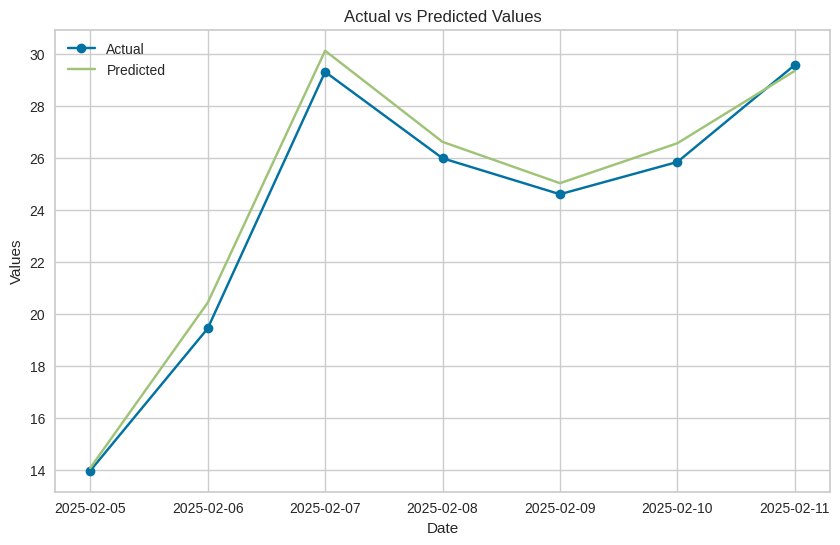

In [207]:
import matplotlib.pyplot as plt

# ค่าจริง (actual values) จาก test_df
actual_values = test_df['pm_2_5']

# ค่าที่ทำนาย (predicted values) จาก predictions_future
predicted_values = predictions_future['y_pred']

# ตรวจสอบขนาดของข้อมูล
print("ขนาด actual_values:", len(actual_values))
print("ขนาด predicted_values:", len(predicted_values))
# เปลี่ยนดัชนีเป็นชนิดที่พลอตได้
actual_values = actual_values.to_timestamp()  # หากเป็นชนิด Period
predicted_values = predicted_values.to_timestamp()  # หากเป็นชนิด Period

# สร้างกราฟ
plt.figure(figsize=(10, 6))  # ตั้งค่าขนาดกราฟ
plt.plot(actual_values.index, actual_values, label='Actual', marker='o')  # พลอตค่าจริง
plt.plot(predicted_values.index, predicted_values, label='Predicted', marker='x')  # พลอตค่าที่ทำนาย

# เพิ่มชื่อกราฟและป้ายชื่อแกน
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
